# Two Means

Simple linear regression attempts to explain a numerical variable based on a linear model.  The line is defined with respect to an x-axis numerical variable.  In this section, we will keep with a numerical variable on the y-axis, but we'll introduce a non-numeric variable on the x-axis.

Consider the dataset $\texttt{carnivora}$, which records a number of variables on the 112 animals from the Order Carnivora.  We are interested trying to predict $\texttt{SW}$, body weight (kg), using the **categorical variable** $\texttt{SuperFamily}$.  The **levels** of the categorical variable $\texttt{SuperFamily}$ are $\texttt{Caniformia}$ and $\texttt{Feliformia}$, which is to say that this dataset contains observations from animals from these two super families of the Order Carnivora.

The most common plot used to visualize the relationship between a numeric y-axis variable with a categorical variable (for now with two levels) is a boxplot.  A boxplot provides a visual representation of the $25\%$, $50\%$, and $75\%$ quantiles.  There's a bit more to it, but we'll focus on a few more advanced plotting ideas than what is most common in practice.

Instead of a boxplot, we'll focus on two plots.  When there is a sufficiently small amount of data, we should make a scatter plot with the points jittered to better visualize the number of observations being plot.  Below is an example where the amount of jitter, random variation introduced along the x-axis (named width), is set to a relatively small number to prevent overlapping from the mutually exclusive groups Caniformia and Feliformia.  This plot ignores the non-numerical nature of the x-axis variable in favor of displaying all the data.

The jittered scatterplot highlights a reasonable rule of thumb for visualization: display as much of the original data as possible, without cluttering the plot.

In [1]:
import numpy as np
import pandas as pd
import bplot as bp
from scipy.optimize import minimize
from scipy.stats import norm as normal
import patsy

bp.LaTeX()
bp.dpi(300)

In [2]:
carnivora = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/carnivora.csv")

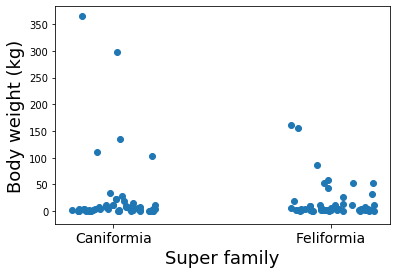

In [18]:
for i, (name, gdf) in enumerate(carnivora.groupby('SuperFamily')):
    y = gdf['SW']
    bp.jitter(np.repeat(i, y.size), y, jitter_y=0)

bp.xticks([0, 1], labels=np.unique(carnivora['SuperFamily']), size=14)
bp.labels(x='Super family', y='Body weight (kg)', size=18)

The other plot we'll use when the y-axis variable is numeric and the x-axis variable is categorical is a violin plot.  A violin plot is a density plot turned vertical and one density plot is made for each level of the x-axis categorical variable.  Below is an example.  The violin plot should be used in addition to the jittered scatter plot, or wherever the former plot is too cluttered to be meaningful.

Both of these plots help the scientist visualize the location of the mean and variation for the y-axis variable, within each level of the x-axis categorical variable.

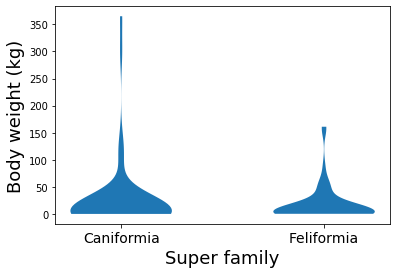

In [4]:
for i, (name, gdf) in enumerate(carnivora.groupby('SuperFamily')):
    y = gdf['SW']
    bp.violin(i, y)

bp.xticks([0, 1], labels=np.unique(carnivora['SuperFamily']), size=14)
bp.labels(x='Super family', y='Body weight (kg)', size=18)

The two means model is the common name for estimating a mean of the y-axis variable, here body weight, for each level of the x-axis variable, here super family.  In reality, it's just estimating means by group when there are exactly two levels within the x-axis grouping variable.

Before we move on, it's informative to see that this model is really doing nothing more than estimating means by group.  The code below, first carefully removes $\texttt{NA}$s, estimates group means using $\texttt{dplyr}$, and then estimates group means using our current model.  The current model produces identical numbers, but only through this intermediate number that doesn't quite make sense yet.

In [5]:
(carnivora
 .groupby('SuperFamily')
 ['SW']
 .agg('mean'))

SuperFamily
Caniformia    23.444211
Feliformia    16.602182
Name: SW, dtype: float64

Model notation is based around the idea of an intercept, despite the fact that the word intercept is not well defined here.  What we mean by intercept in this context is the mean value of body weight, the y-axis variable, for the first level of the x-axis variable, here Caniformia.  In $\texttt{R}$, the first level will always be the alphabetically or numerically first level contained in the x-axis categorical variable.

For the body weight data, $\texttt{SW}$, we assume

$$ Y_1, \ldots, Y_N \sim_{iid} \text{Normal}(\mu, \sigma^2) \\
\mu = \beta_0 + \beta_1 * Feliformia.$$

There are three pieces to this model that deserve special attention.  The first thing to notice is that the structure of the model looks identical to simple linear regression.  This similarity will allow us to unify these two models in coming sections of these course notes.  The difference between simple linear regression and this model rests on the (statistical) type of the x-axis variable, which brings us to the other pieces that deserve special attention.  

The second point to note is that Feliformia is not a numerical variable, like in simple linear regression.  In the world of statistics, Feliformia in this context is called an indicator variable.  Indicator variables only ever take on two values, $0$ and $1$.  Feliformia will be $1$ when predicting or calculating the mean body weight for an animal from the super family Feliformia, and $0$ otherwise.

The third point to note is that Caniformia does not obviously show up in this model.  It's only when predicting or calculating the mean body weight for an animal from the super family Caniformia that Feliformia is $0$ and thus the term $\beta_0$ represents Caniformia's mean body weight.

The main difference between simple linear regression and this model is the type of the x-axis variable.  In simple linear regression the x-axis variable is numerical.  Here, the x-axis variable is categorical.  This changes our interpretation of the current model.

Now, the "intercept" $\beta_0$ is Caniformia's mean body weight, and the "slope" $\beta_1$ is the offset for Feliformia, relative to Caniformia.  That is, if you take $\hat{\beta}_0$ and add it to $\hat{\beta}_1$, you'll get the estimated mean body weight for Feliformia.

The code to fit this model is very similar to the code for simple linear regression.

In [6]:
def ll(beta, yX):
    y = yX[:, 0]
    X = yX[:, -2:]
    yhat = np.full(y.shape, np.nan)
    for r in range(X.shape[0]):
        yhat[r] = np.sum(beta * X[r,:])
    d = y - yhat
    return np.sum(d * d)

pX = patsy.dmatrix("~ C(SuperFamily)", data=carnivora)
yX = np.c_[carnivora['SW'], np.asarray(pX)]

beta = minimize(ll, normal.rvs(loc=50, size=2), args=(yX))['x']

Notice that $X$ again has two columns.

In [7]:
pX

DesignMatrix with shape (112, 2)
  Intercept  C(SuperFamily)[T.Feliformia]
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
          1                             0
 

The first column, as in simple linear regression, is called the intercept and is always $1$.  The second column is $0$ when an observation (row) represents an animal from the super family Caniformia, and is $1$ when an observation represents an animal from the super family Feliformia.  Notice then that the model uses both $\beta_0$ and $\beta_1$ to estimate the mean for members of the super family Feliformia.  This explains why $\beta_1$ is the offset for Feliformia relative to (the ever present) group mean $\beta_0$ for Caniformia.  In the world of data science, they say the variable $\texttt{Feliformia}$ is [one-hot encoded](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for the observations which are members of the super family Feliformia.  

In [52]:
print(yX[:5, -2:]) # first 5 rows as seen inside ll()
print(yX[-5:, -2:]) # last 5 rows as seen inside ll()

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


With this in mind, we can recover the two means of body weight for Caniformia and Feliformia.  Caniformia's estimated mean body weight is $\hat{\beta}_0$ and Feliformia's estimated mean body weight is $\hat{\beta}_0 + \hat{\beta}_1$.

In [10]:
print(beta[0])
print(sum(beta))

23.44420985025349
16.60218337331331


The interpretation of each group's mean is the same as interpretting a single mean.

Quantifying uncertainty in our estimates is carried out with the bootstrap method.

In [12]:
N = carnivora['SW'].size
R = 999
betas = np.full((R, 2), np.nan)

for r in range(R):
    idx = np.random.choice(N, N)
    betas[r, :] = minimize(ll, normal.rvs(loc=20, size=2), args=(yX[idx, :]))['x']

In [13]:
beta_p = np.percentile(betas, [10, 90], axis=0)

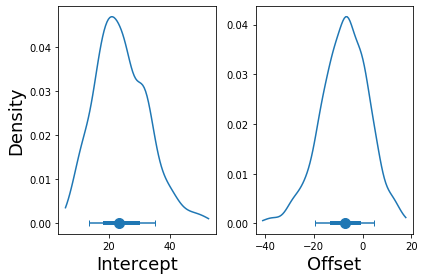

In [17]:
axs = bp.subplots(1, 2)

ylab = lambda x: "Density" if x < 1 else ""
xlab = lambda x: f"$\\beta_{ {x} }$"
for a in range(len(axs)):
    bp.current_axis(axs[a])
    bp.density(betas[:, a])
    bp.percentile_h(betas[:, a], y=0)
    bp.rug(beta_p[:, a])
    bp.labels(x=xlab(a), y=ylab(a), size=18)
    
bp.tight_layout()

Plotting the bootstrap estimated sampling distributions for Feliformia's offset gives good idea of the similarlity between Caniformia and Feliformia.

The summary statistics above, including the plots, suggest that there's a reasonable chance that the mean body weight for Feliformia is roughly equal to that of Caniformia.  But be careful with this conclusion, because the violin plot above shows that there's some members of the super family Caniformia that are always heavier than some members of Feliformia.  Do you know which animals these are?